In [2]:
# Note by XO on 01/24/2022: This is an HDBSCAN clustering result analysis script. 
# We apply the clustering algorithm again on the means of the earlier clustering result and 
# and test the robustness of them by checking the size of each cluster of clusters
# Import libraries
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Ellipse
from matplotlib.colors import ListedColormap, Normalize, LogNorm
from scipy.interpolate import interpn
import seaborn as sns

cmap = ListedColormap(sns.color_palette("colorblind",256))
pal = sns.color_palette('colorblind', 256)

import astropy.coordinates as coord
import astropy.units as u

label_size = 24
matplotlib.rc('font', size=label_size) 

import sklearn
# print(sklearn.__version__)
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
import hdbscan

import warnings
warnings.filterwarnings("once")

In [3]:
# Define a function to plot the clusters means
def plot_clusters(means, dispersions, x_label, y_label, xlim_l, xlim_u, ylim_l, ylim_u, c_list,
                  add_data=[], add_err=[], add_c_list=[],
                  fig_size = [4,1], n_dim = 3, n_row = 1, n_col = 3, 
                  x_ax = [0,0,2], y_ax = [1,2,1], 
                  err_bar = True, f_name=None):
    assert (len(means[0]) == len(dispersions[0])) and (len(means[0]) == len(x_label)) and (len(y_label) == len(x_label))
    
    f = plt.figure(figsize=fig_size)
    
    for i in range(n_row):
        for j in range(n_col):
            k = i+j
            plt.subplot(n_row, n_col, k+1)
            if err_bar == True:
                plt.errorbar(x=means[:,x_ax[k]], y=means[:,y_ax[k]], xerr=dispersions[:,x_ax[k]], yerr=dispersions[:,y_ax[k]],
                             linestyle='none',c=c_list,markersize=10)
                if len(add_data) != 0 and len(add_err) != 0:
                    plt.errorbar(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]], xerr=add_err[:,x_ax[k]], yerr=add_err[:,y_ax[k]],
                                 linestyle='none',c=add_c_list,markersize=5)
                elif len(add_data) != 0 and len(add_err) == 0: 
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
            else:
                plt.scatter(x=means[:,x_ax[k]], y=means[:,y_ax[k]],c=c_list,s=10)
                if len(add_data) != 0:
                    plt.scatter(x=add_data[:,x_ax[k]], y=add_data[:,y_ax[k]],c=add_c_list,s=5)
                
            plt.xlabel(x_label[k])
            plt.ylabel(y_label[k])
            plt.xlim([xlim_l[k],xlim_u[k]])
            plt.ylim([ylim_l[k],ylim_u[k]])
    
    plt.tight_layout()
    
    if f_name != None:
        f.savefig(f_name)
    
    plt.show()
            

In [530]:
# Import data for testing approximate_predict of hdbscan
# Try predicting the stars membership to the cluster of clusters
cm_vel_all = pd.read_hdf('../data/dr3_near_vel_plxzp_g2_only.h5')
orb_param_all = pd.read_hdf('../data/dr3_orb_param_err_g2_only.h5')

# My selection
cutoff = 3500 # pc
# Pick the stars with reasonable velocities(need to jutify this later)
# and reasoanable metallicity 
# and meet all quality cuts except for the binary cut
# Temporarily ignoring any action flags and not using any action for now
kin_qual = ((abs(cm_vel_all['U_g2']) < 1000) & 
            (abs(cm_vel_all['V_g2']) < 1000) & (abs(cm_vel_all['W_g2']) < 1000) & 
            (cm_vel_all['qual_flag'] == 0) # & 
           )

selection = ((orb_param_all['zmax']-2*orb_param_all['e_zmax']) > cutoff)

combined_cut = kin_qual & selection

ind_cut = np.where(combined_cut)[0]
print("Sample size after cut:",len(ind_cut))

# Cut the dataframe
df_cut_vel = cm_vel_all.loc[ind_cut,:]
df_cut_orb = orb_param_all.loc[ind_cut,:]

Sample size after cut: 8166


In [4]:
# Import data of results from the random resampling clustering
data_dir = './E_L_2500_data_20_20_err_5per/'
extratext = '_0210_g2only_err_rel_cut_5per_etot_Lz_Lperp_zmax_cut_2500_hdbscan_min_samples_20_min_clustsize_20_leaf_samp_'
# cluster_id = np.load(data_dir + 'member_gedr3id' + extratext + '.npy',allow_pickle=True)
# cluster_ind = np.load(data_dir + 'member_mask' + extratext + '.npy',allow_pickle=True)
# cluster_col = np.load(data_dir + 'color' + extratext + '.npy',allow_pickle=True)
# cluster_nstar = np.load(data_dir + 'member_nstar' + extratext + '.npy',allow_pickle=True)
# cluster_means = np.load(data_dir + 'member_means' + extratext + '.npy',allow_pickle=True)
# cluster_dispersions = np.load(data_dir + 'member_disps' + extratext + '.npy',allow_pickle=True)

N_samp = 100

# Find all the files
samp_list = np.arange(N_samp,dtype=int)
mean_path_list = []
disp_path_list = []
nstar_path_list = []


for i in range(N_samp):
    mean_file_name = glob.glob(data_dir+'member_means'+ extratext + str(samp_list[i])+'.npy')[0]
    disp_file_name = glob.glob(data_dir+'member_disps'+ extratext + str(samp_list[i])+'.npy')[0]
    nstar_file_name = glob.glob(data_dir+'member_nstar'+ extratext + str(samp_list[i])+'.npy')[0]
    mean_path_list.append(mean_file_name)
    disp_path_list.append(disp_file_name)
    nstar_path_list.append(nstar_file_name)

N_files = len(mean_path_list)


# Import files into arrays
mean_result_list = []
disp_result_list = []
nstar_result_list = []

for i in range(0,N_files):
    print('Appending file #',i)
    mean_result_list.append(np.load(mean_path_list[i],allow_pickle=True))
    disp_result_list.append(np.load(disp_path_list[i],allow_pickle=True))
    nstar_result_list.append(np.load(nstar_path_list[i],allow_pickle=True))
    print(len(mean_result_list[i]),len(disp_result_list[i]),len(nstar_result_list[i]))

Appending file # 0
60 60 60
Appending file # 1
60 60 60
Appending file # 2
60 60 60
Appending file # 3
60 60 60
Appending file # 4
60 60 60
Appending file # 5
60 60 60
Appending file # 6
60 60 60
Appending file # 7
60 60 60
Appending file # 8
60 60 60
Appending file # 9
60 60 60
Appending file # 10
60 60 60
Appending file # 11
60 60 60
Appending file # 12
60 60 60
Appending file # 13
60 60 60
Appending file # 14
60 60 60
Appending file # 15
60 60 60
Appending file # 16
60 60 60
Appending file # 17
60 60 60
Appending file # 18
60 60 60
Appending file # 19
60 60 60
Appending file # 20
60 60 60
Appending file # 21
60 60 60
Appending file # 22
60 60 60
Appending file # 23
60 60 60
Appending file # 24
60 60 60
Appending file # 25
60 60 60
Appending file # 26
60 60 60
Appending file # 27
60 60 60
Appending file # 28
60 60 60
Appending file # 29
60 60 60
Appending file # 30
60 60 60
Appending file # 31
60 60 60
Appending file # 32
60 60 60
Appending file # 33
60 60 60
Appending file # 34
60 6

In [5]:
extratext[:-6]

'_0207_g2only_err_etot_Lz_Lperp2500_hdbscan_min_samples_20_min_clustsize_20_leaf'

In [6]:
# Examine the seeds
seed_rand_arr = np.load(data_dir+'random_seed'+extratext[:-6]+'.npy')
print(seed_rand_arr)

[6252 4684 1731 4742 4521 6340  576 5202 6363  439 2750 7487 5272 5653
 3999 6033  582 9930 7051 8158 9896 2249 4640 9485 4947 9920 1963 8243
 6590 8847  321 2678 4625 4949 8328 3337 5589  251 3973 6630 5547   35
 8362 1513 9317   39 4819 3465 1760 2304 3723 8284 4993 8127 3032 7938
 3039 9655 2545 2592 1188 7966 6077  107 1315 8187 2753 9753 6231 2876
 5323  799 3570 2894 2927 8178  971 6687 8575 2020 9054  952 5359 3857
 5861 3145 3305 3006 9001 7770 7438 7942 9238 1056 3154 3787 9189 7825
 7539 7231]


In [7]:
# Combine the data and get rid of the zero star clusters (from default prepared arrays)

# Count the number of cluster in each trial
nclu_arr = np.zeros(N_samp,dtype=int)
for i in range(N_samp):
    nclu = len(np.where(nstar_result_list[i] != 0)[0])-1
    nclu_arr[i] = nclu


# print(nclu_arr)

# Pick out the cluster means and dispersions
mean_comb = mean_result_list[0][0:nclu_arr[0]]
disp_comb = disp_result_list[0][0:nclu_arr[0]]
nstar_comb = nstar_result_list[0][0:nclu_arr[0]]

# Also create a label for identifying which trial each cluster came from
clust_lbl_comb = [0]*nclu_arr[0]

for i in range(1,N_samp):
    mean_comb = np.vstack((mean_comb,mean_result_list[i][0:nclu_arr[i]]))
    disp_comb = np.vstack((disp_comb,disp_result_list[i][0:nclu_arr[i]]))
    nstar_comb = np.concatenate((nstar_comb,nstar_result_list[i][0:nclu_arr[i]]))
    clust_lbl_comb = clust_lbl_comb+[i]*nclu_arr[i]

clust_lbl_comb = np.array(clust_lbl_comb)
# Count total number of cluster
print("Total number of clusters across",N_samp,"realizations is",len(mean_comb),len(disp_comb),len(nstar_comb),len(clust_lbl_comb))

Total number of clusters across 100 realizations is 2613 2613 2613 2613


In [8]:
plot_dir = './E_L_2500_plot_20_20/'

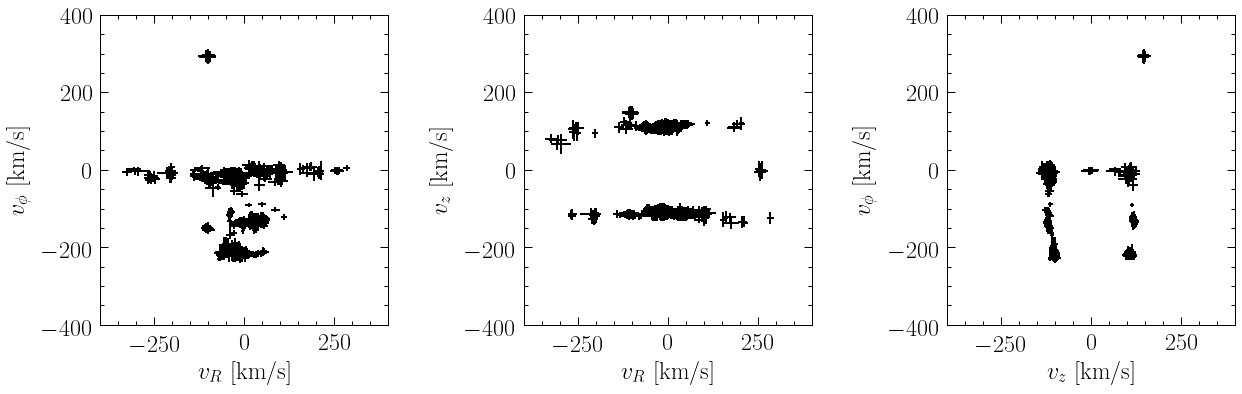

In [154]:
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=['k']*len(mean_comb),
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = True, f_name=plot_dir+'cluster_bg_w_dispersion.pdf')

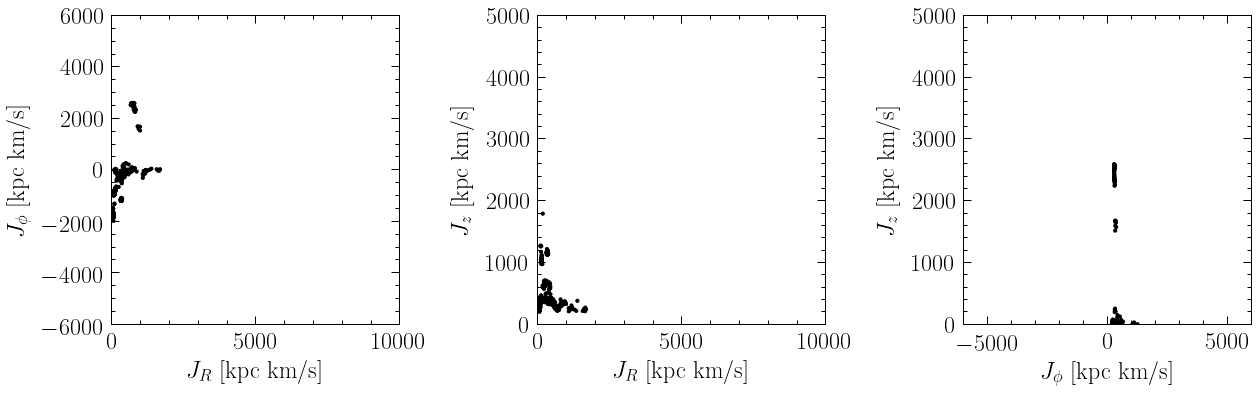

In [462]:
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
#               xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
#               ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=['k']*len(mean_comb),
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False, f_name=plot_dir+'cluster_bg.pdf')

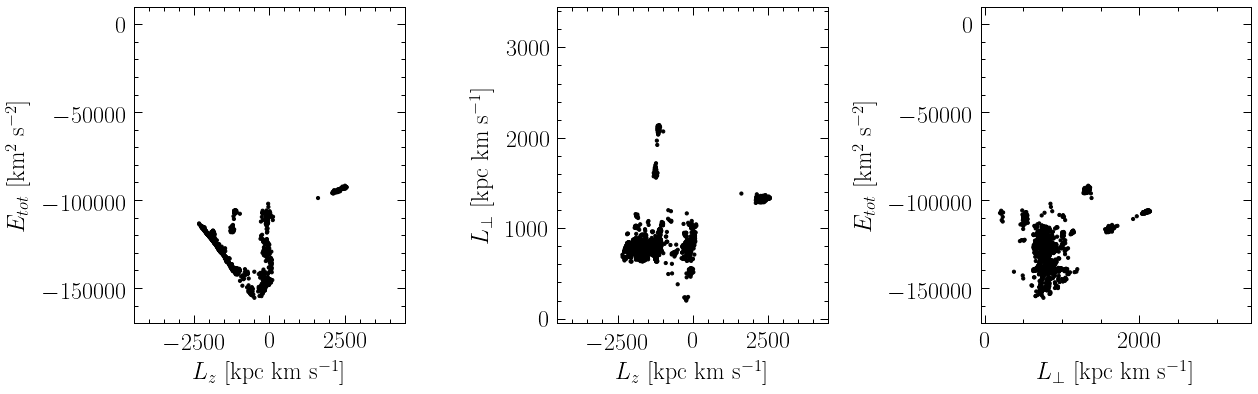

In [19]:
plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$L_z$ [kpc km s$^{-1}$]', r'$L_z$ [kpc km s$^{-1}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]'], 
              y_label=[r'$E_{tot}$ [km$^2$ s$^{-2}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]', r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
              xlim_l=[-4500,-4500,-50], xlim_u=[4500,4500,3450], 
              ylim_l=[-170000,-50,-170000], ylim_u=[10000,3450,10000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=['k']*len(mean_comb),
              x_ax = [1,1,2], y_ax = [0,2,0], 
              err_bar = False, f_name=plot_dir+'cluster_bg.pdf')

In [534]:
print(np.shape(mean_comb))

(746, 3)


Starting trial # 0
Not sampling inputs...
Scaling inputs...
Shape of X: (2613, 3)
Extra text is: _0207_EL2500_robustness_test_hdbscan_min20_eom
3
Start clustering
Estimated number of clusters: 29
Estimated number of noise points: 608
unique_labels are {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, -1}
k is 0
k is 1
k is 2
k is 3
k is 4
k is 5
k is 6
k is 7
k is 8
k is 9
k is 10
k is 11
k is 12
k is 13
k is 14
k is 15
k is 16
k is 17
k is 18
k is 19
k is 20
k is 21
k is 22
k is 23
k is 24
k is 25
k is 26
k is 27
k is 28
k is -1
Shape of member clusters (30, 2613)
Exporting results...


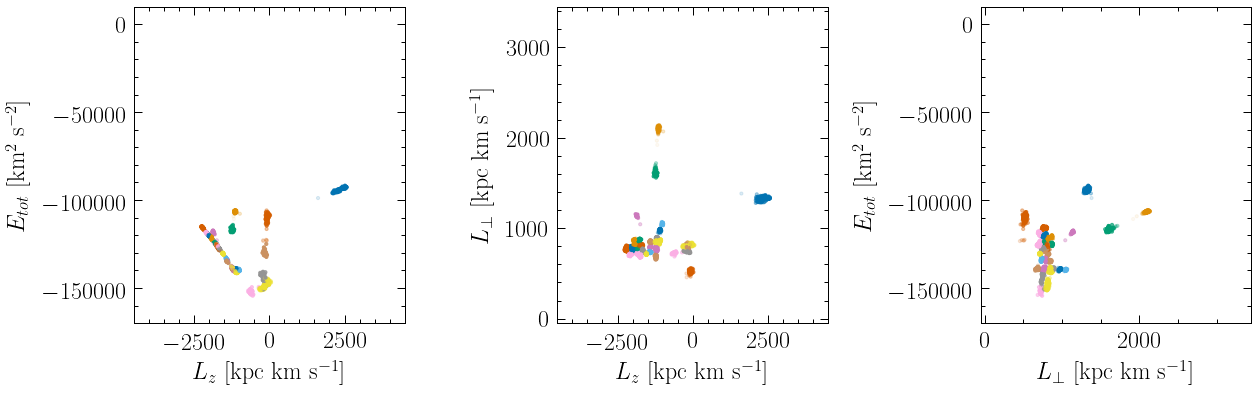

In [12]:
# Re-cluster with these means
# Tweak with the axes that go into PCA

scaler = 'Robust' # 'Standard' or 'Robust' or None
denoise = None # 'PCA' or 'AE' or None
algorithm = 'HDBSCAN' # 'OPTICS' or 'DBSCAN' or 'HDBSCAN' or 'AGG_n' or 'AGG_l' or 'GMM'

# Restart an extratext
extratext = '_0207_EL2500_robustness_test'

# Clustering options
if algorithm == 'DBSCAN':
    eps = 0.1
    extratext += '_eps01'
    min_samples = 10
    extratext += '_min'+str(min_samples)
elif algorithm == 'OPTICS':
    min_samples = 12
    extratext += '_opt'
    extratext += '_min'+str(min_samples)
elif algorithm == 'HDBSCAN':
    extratext += '_hdbscan'
#     cluster_selection_epsilon = 0.
#     extratext += '_eps0'
#     min_samples = 3
    min_cluster_size = 20
    extratext += '_min'+str(min_cluster_size)
    cluster_selection_method = 'eom'
    extratext += '_'+str(cluster_selection_method)
elif algorithm == 'AGG_n':
    # Use n_clusters
    extratext += '_agglomerative'
    n_cluster = 3
    linkage_threshold = None
    extratext += '_n_clust_'+str(n_cluster)
elif algorithm == 'AGG_l':
    # Use linkage_threshold
    extratext += '_agglomerative'
    n_cluster = None
    linkage_threshold = 25
    extratext += '_l_threshold_25'
elif algorithm == 'GMM':
    extratext += '_gmm'

# Decomposition options
if denoise == 'PCA':
    extratext += '_PCA'
    n_pca_comp = 2
    extratext += '_ncomp_'+str(n_pca_comp)


# Add in the dimensions as needed 
ydata = np.copy(mean_comb)
ydata_err = np.copy(disp_comb)

# Sample the ydata before feeding into scaler and the clustering algorithm
np.random.seed(42)

# Generate a random list of seed from the single seed specified above
N_samp = 1
# rand_seed_list = np.random.choice(np.arange(10000,dtype=int),N_samp,replace=False)
# print(rand_seed_list)

# save the random seeds
# np.save(data_dir + 'random_seed' + extratext + '.npy', rand_seed_list)

# Generate the random initial conditions assuming all inputs are independent without covariance
# this is not true since cylindrical velocities are definitely correlated
# Energies/actions are also calculated by sampling velocities, so there must be correlations.
for i in range(N_samp):
    print("Starting trial #",i)
    ydata_samp = np.zeros(np.shape(ydata))
    np.random.seed(42)
    
#     print("Sampling inputs...")
#     for j in range(len(ydata_samp[0,:])):
#         ydata_samp[:,j] = np.random.normal(ydata[:,j], ydata_err[:,j])
        
    print("Not sampling inputs...")
    ydata_samp = ydata


    print("Scaling inputs...")
    if denoise == None:
        if scaler == 'Standard':
            X = StandardScaler().fit_transform(ydata_samp)
        elif scaler == 'Robust':
            X = RobustScaler().fit_transform(ydata_samp)
        elif scaler == None:
            X = ydata_samp
    elif denoise == 'PCA':
        if scaler == None:
            X = PCA().fit_transform(ydata_samp)
        elif scaler == 'Standard':
            X = StandardScaler().fit_transform(PCA().fit_transform(StandardScaler().fit_transform(ydata_samp)))
        elif scaler == 'Robust':
            X = RobustScaler().fit_transform(PCA().fit_transform(RobustScaler().fit_transform(ydata_samp)))    

    # Print the explained variance ratios
    if denoise == 'PCA':
#         print("Axes in PCA:",pca_list)
        print("Explained variance ratios from PCA:",PCA().fit(StandardScaler().fit_transform(ydata_samp)).explained_variance_ratio_)
#         print("Shape of X before adding additional axes:",np.shape(X[:,:n_pca_comp]))
    else:
        pass
#         print("Axes not in PCA:",pca_list)

    
    
    if i == 0:
        print("Shape of X:",np.shape(X))
        print("Extra text is:",extratext)
    
    # Prepare arrays to store the results
    n_clusters_estimated = 50
    
    n_dim = len(mean_comb[0])

    cluster_means = np.zeros((n_clusters_estimated, n_dim))
    cluster_dispersions = np.zeros((n_clusters_estimated, n_dim))    
    cluster_ncluts = np.zeros((n_clusters_estimated))
    if i == 0:
        print(n_dim)

    
    # Start clustering
    print("Start clustering")
    if algorithm == 'DBSCAN':
        # Apply DBSCAN
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
    elif algorithm == 'OPTICS':
        # Apply OPTICS
        clust = OPTICS(min_samples=min_samples, max_eps = 2).fit(X)
        labels = clust.labels_ #[clust.ordering_]
    #         core_samples_mask = np.zeros_like(labels, dtype=bool)
    #         core_samples_mask[clust.core_sample_indices_] = True
    elif algorithm == 'HDBSCAN':
        # Apply HDBSCAN
        clust = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,  
                                gen_min_span_tree=True, 
                                cluster_selection_method=cluster_selection_method, 
                                prediction_data=True).fit(X)
    #         clust = hdbscan.HDBSCAN().fit(X)
        labels = clust.labels_ #[clust.ordering_]
    elif algorithm == 'AGG_n' or algorithm == 'AGG_l':
        clust = AgglomerativeClustering(n_clusters=n_cluster,distance_threshold=linkage_threshold).fit(X)
        labels = clust.labels_
    elif algorithm == 'GMM':
        # Fix the random seed
        np.random.seed(0)
        # Find the best N_clust
        N = np.arange(3, n_clusters_estimated)
        models = [None for n in N]

        for i in range(len(N)):
            models[i] = GaussianMixture(N[i], covariance_type='full',reg_covar=1e-06).fit(X)

        AIC = [m.aic(X) for m in models]
        BIC = [m.bic(X) for m in models]

        # Auto determine the best GMM cluster number
        i_best = np.argmin(BIC)
        # Manual determine the best GMM cluster number
        i_best = 6
        print('best fit N components manually set!')
        gmm_best = models[i_best]
        print('best fit converged:', gmm_best.converged_)
        print('number of interations =', gmm_best.n_iter_)
        print('BIC: N components = %i' % N[i_best])

        plt.plot(N, AIC, 'r-', label='AIC')
        plt.plot(N, BIC, 'b--', label='BIC')
        plt.xlabel('number of components')
        plt.ylabel('information criterion')
        plt.legend(loc=2, frameon=False)
        plt.show()

        labels = gmm_best.predict(X)



    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    # print("Silhouette Coefficient: %0.3f"
    #       % metrics.silhouette_score(X, labels))



    # ###########################################################################

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    print("unique_labels are", unique_labels)

    colors = [cmap(each)
              for each in unique_labels]
    col_list = [cmap(col)[0:3]+ (sat,) for col, sat in zip(labels, clust.probabilities_)]
    
      
    
    # Make an empty list to save the indices
    mask_list = []
    lab_list = []
    id_list = []

    # Make a separate source_id array for later extraction
    # Used to accomodate situations where we have additional cuts on top of the 
    # initial quality cut
#     ind_add_cut = ind_cut[:]
#     X_source_id = df_cut_vel.loc[ind_add_cut,'source_id']


    for k, col in zip(unique_labels, colors):
        print("k is", k)
        if k == -1:
            # Black used for noise.
            col = [0., 0., 0., 0.]

        class_member_mask = (labels == k)

        if algorithm == 'DBSCAN':
            mask = class_member_mask & core_samples_mask
            anti_mask = class_member_mask & ~core_samples_mask
        elif algorithm == 'OPTICS' or algorithm == 'HDBSCAN' or algorithm == 'AGG_n' or algorithm == 'AGG_l' or algorithm == 'GMM':
            mask = class_member_mask
            anti_mask = class_member_mask

        
        xy = ydata_samp[mask]
        cluster_means[k] = np.mean(xy, axis = 0)
        cluster_dispersions[k] = np.std(xy, axis = 0)
        cluster_ncluts[k] = len(X[class_member_mask])
        
        
        # Record the indices and colors
        mask_list.append(mask)
#         id_list.append(X_source_id[mask].values)
        lab_list.append(str(k))


    print("Shape of member clusters", np.shape(mask_list))
    print("Exporting results...")
#     np.save(data_dir + 'member_mask' + extratext + '_samp_' + str(i) + '.npy', mask_list)
#     np.save(data_dir + 'member_gedr3id' + extratext + '_samp_' + str(i) + '.npy', id_list)
#     np.save(data_dir + 'color' + extratext + '_samp_' + str(i) + '.npy', colors) # Note that the last color correcponds to noise and is not used
#     np.save(data_dir + 'member_means' + extratext + '_samp_' + str(i) + '.npy', cluster_means)
#     np.save(data_dir + 'member_disps' + extratext + '_samp_' + str(i) + '.npy', cluster_dispersions)
#     np.save(data_dir + 'member_nstar' + extratext + '_samp_' + str(i) + '.npy', cluster_nstars)

#     plot_clusters(mean_comb, disp_comb, 
#                   x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#                   y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#                   xlim_l=[-400]*3, xlim_u=[400]*3, 
#                   ylim_l=[-400]*3, ylim_u=[400]*3, 
#                   fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#                   x_ax = [0,0,2], y_ax = [1,2,1], 
#                   err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_all.pdf')

#     plot_clusters(mean_comb, disp_comb, 
#                   x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
#                   y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
#                   xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
#                   ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
#                   fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#                   x_ax = [0,0,2], y_ax = [1,2,1], 
#                   err_bar = False, f_name=plot_dir+'hdbscan_on_cluster_all.pdf')

    plot_clusters(mean_comb, disp_comb, 
                  x_label=[r'$L_z$ [kpc km s$^{-1}$]', r'$L_z$ [kpc km s$^{-1}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]'], 
                  y_label=[r'$E_{tot}$ [km$^2$ s$^{-2}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]', r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
                  xlim_l=[-4500,-4500,-50], xlim_u=[4500,4500,3450], 
                  ylim_l=[-170000,-50,-170000], ylim_u=[10000,3450,10000], 
                  fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
                  x_ax = [1,1,2], y_ax = [0,2,0], 
                  err_bar = False, f_name=plot_dir+'hdbscan_on_cluster_all.pdf')


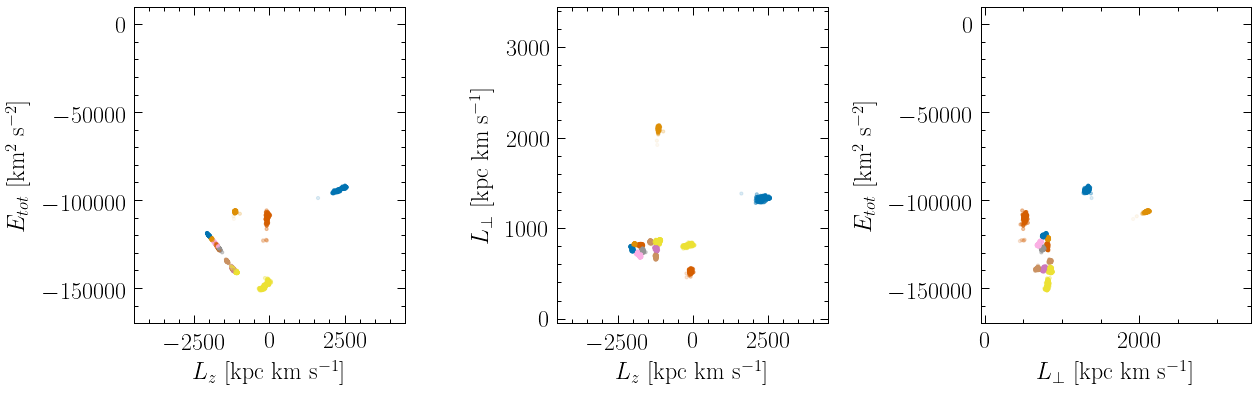

In [16]:
# Only plot the ones with more than 70 clusters in it
mask_list = np.array(mask_list)
col_list_robust = np.copy(col_list)
mask_not_robust = (cluster_ncluts[0:n_clusters_] < 70)

for i in np.arange(len(mask_not_robust))[mask_not_robust]:
    col_list_robust[mask_list[i],3] = 0.
    
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False, f_name=plot_dir+'hdbscan_on_cluster_robust.pdf')

# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
#               y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
#               xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
#               ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False, f_name=plot_dir+'hdbscan_on_cluster_robust.pdf')

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$L_z$ [kpc km s$^{-1}$]', r'$L_z$ [kpc km s$^{-1}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]'], 
              y_label=[r'$E_{tot}$ [km$^2$ s$^{-2}$]', r'$L_{\bot}$ [kpc km s$^{-1}$]', r'$E_{tot}$ [km$^2$ s$^{-2}$]'], 
              xlim_l=[-4500,-4500,-50], xlim_u=[4500,4500,3450], 
              ylim_l=[-170000,-50,-170000], ylim_u=[10000,3450,10000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
              x_ax = [1,1,2], y_ax = [0,2,0], 
              err_bar = False, f_name=plot_dir+'hdbscan_on_cluster_robust.pdf')

In [14]:
ind_not_robust = np.arange(len(mask_not_robust))[mask_not_robust]

In [15]:
# Examine the probabilities
print(len(clust.probabilities_))
print(clust.labels_[0:10],clust.probabilities_[0:10])

2613
[ 0  1  3 -1  8  9 10 13 16 11] [0.60552157 0.30145917 1.         0.         1.         1.
 0.92485498 0.97563551 0.83178812 1.        ]


In [539]:
# Now process the stars data for feeding into approximate_predict
# Add in the dimensions as needed 
s_ydata_ini = []
s_ydata_ini_err = []

# s_ydata_ini.append(df_cut_vel["vr_g2"])
# s_ydata_ini.append(df_cut_vel["vphi_g2"])
# s_ydata_ini.append(df_cut_vel["vz_g2"])
# s_ydata_ini_err.append(df_cut_vel["vrerr_g2"])
# s_ydata_ini_err.append(df_cut_vel["vphierr_g2"])
# s_ydata_ini_err.append(df_cut_vel["vzerr_g2"])

s_ydata_ini.append(df_cut_orb['JR'])
s_ydata_ini.append(df_cut_orb['Jphi'])
s_ydata_ini.append(df_cut_orb['Jz'])
s_ydata_ini_err.append(df_cut_orb['e_JR'])
s_ydata_ini_err.append(df_cut_orb['e_Jphi'])
s_ydata_ini_err.append(df_cut_orb['e_Jz'])

s_ydata = np.array(s_ydata_ini).T
s_ydata_err = np.array(s_ydata_ini_err).T

s_X = RobustScaler().fit(ydata_samp).transform(s_ydata)

pred_labels, pred_strengths = hdbscan.approximate_predict(clust, s_X)

s_col_list = [cmap(col)[0:3]+ (sat,) for col, sat in zip(pred_labels, pred_strengths)]

s_col_list_robust = np.copy(s_col_list)

for i in range(len(pred_labels)):
    if pred_labels[i] in np.arange(len(mask_not_robust))[mask_not_robust]:
        s_col_list_robust[i,3] = 0.

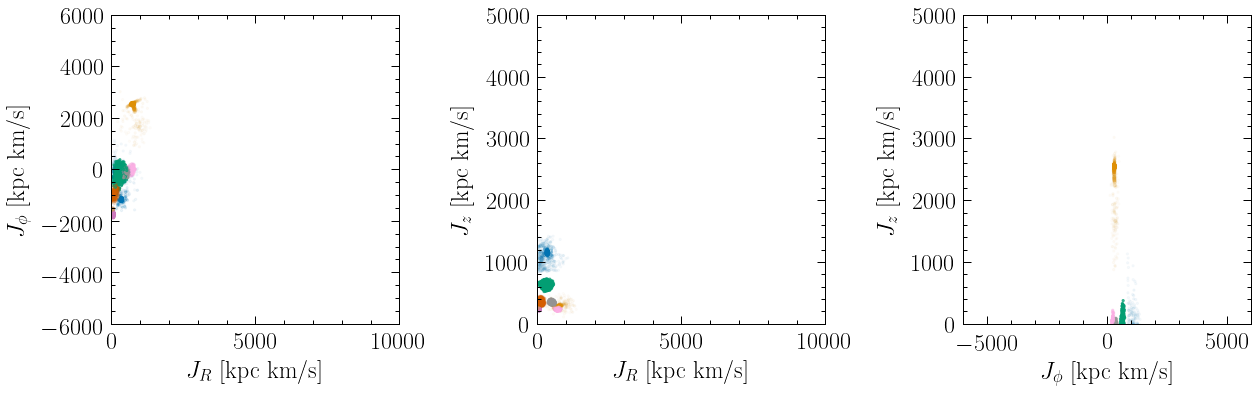

In [540]:
# Plot all clusters of clusters, as well as the stars predicted
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
#               add_data=s_ydata, add_err=[], add_c_list=s_col_list,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_all_w_pred.pdf')

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
              y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
              xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
              ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list,
              add_data=s_ydata, add_err=[], add_c_list=s_col_list,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_all_w_pred.pdf')

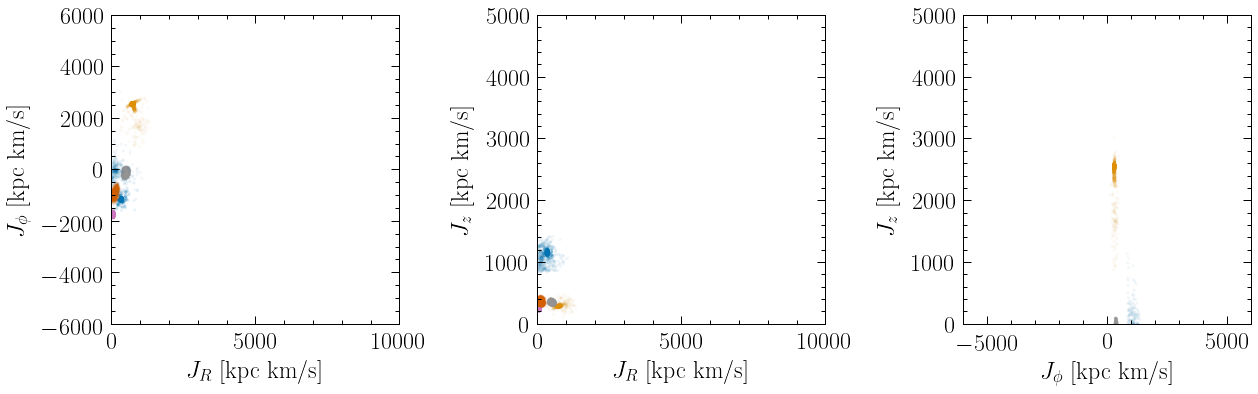

In [541]:
# Plot only robust clusters of clusters, as well as the stars predicted to be part of robust clusters
# plot_clusters(mean_comb, disp_comb, 
#               x_label=[r'$v_{R}$ [km/s]', r'$v_{R}$ [km/s]', r'$v_{z}$ [km/s]'], 
#               y_label=[r'$v_{\phi}$ [km/s]', r'$v_{z}$ [km/s]', r'$v_{\phi}$ [km/s]'], 
#               xlim_l=[-400]*3, xlim_u=[400]*3, 
#               ylim_l=[-400]*3, ylim_u=[400]*3, 
#               fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
#               add_data=s_ydata, add_err=[], add_c_list=s_col_list_robust,
#               x_ax = [0,0,2], y_ax = [1,2,1], 
#               err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_robust_w_pred.pdf')

plot_clusters(mean_comb, disp_comb, 
              x_label=[r'$J_{R}$ [kpc km/s]', r'$J_{R}$ [kpc km/s]', r'$J_{\phi}$ [kpc km/s]'], 
              y_label=[r'$J_{\phi}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]', r'$J_{z}$ [kpc km/s]'], 
              xlim_l=[0,0,-6000], xlim_u=[10000,10000,6000], 
              ylim_l=[-6000,0,0], ylim_u=[6000,5000,5000], 
              fig_size = [18,6], n_dim = 3, n_row = 1, n_col = 3, c_list=col_list_robust,
              add_data=s_ydata, add_err=[], add_c_list=s_col_list_robust,
              x_ax = [0,0,2], y_ax = [1,2,1], 
              err_bar = False , f_name=plot_dir+'hdbscan_on_cluster_robust_w_pred.pdf')

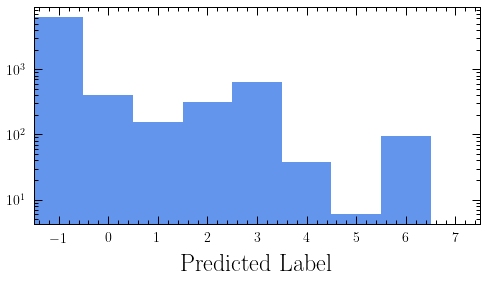

In [542]:
# Characterize the star prediction result
f, ax = plt.subplots(figsize=[8,4])
plt.hist(pred_labels,bins=np.arange(-1.5,n_clusters_-0.5))
ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20,integer=True))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.yscale('log')
plt.xlim([-1.5,n_clusters_-0.5])
plt.xlabel('Predicted Label')
plt.show()
f.savefig(plot_dir+'hdbscan_on_cluster_pred_label_hist.pdf')

In [543]:
# Count predicted noise
print('Number of stars predicted as noise:'+str(len(pred_strengths[pred_labels == -1])))

# Count predicted noise + in non-robust cluster 
count = len(pred_strengths[pred_labels == -1])
for i in ind_not_robust:
    print(len(pred_strengths[pred_labels == i]))
    count += len(pred_strengths[pred_labels == i])
print('Number of stars predicted as noise or in a not robust cluster:',count)
# print(len(pred_strengths[(pred_labels in ([-1] + list(ind_not_robust)))]))

Number of stars predicted as noise:6389
311
6
95
Number of stars predicted as noise or in a not robust cluster: 6801


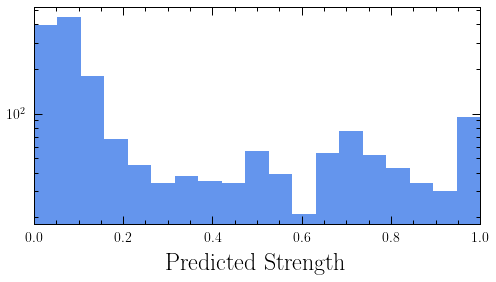

In [544]:
# Examine the prediction strength, excluding all the stars predicted as noise, which always have strength = 0
f, ax = plt.subplots(figsize=[8,4])
plt.hist(pred_strengths[pred_labels != -1],bins=np.linspace(0,1,20))
plt.yscale('log')
# ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=20,integer=True))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([0,1])
plt.xlabel('Predicted Strength')
plt.show()
f.savefig(plot_dir+'hdbscan_on_cluster_pred_stren_hist.pdf')

In [545]:
print(np.shape(pred_labels),np.shape(pred_strengths))
print(pred_labels[0:10],pred_strengths[0:10])

(8166,) (8166,)
[-1 -1 -1  4 -1 -1 -1 -1 -1 -1] [0.         0.         0.         0.34330843 0.         0.
 0.         0.         0.         0.        ]


In [546]:
print(len(np.arange(len(mask_not_robust))[mask_not_robust]))

3


In [547]:
for i in np.arange(len(mask_not_robust))[mask_not_robust]:
    print(i)

2
5
6


In [17]:
print(cluster_ncluts)

[101. 100.  40.  80.  24.  23.  27.  39. 115.  32.  61.  34.  35.  59.
  29. 109.  42.  26. 180.  28. 112.  76.  24. 127. 104. 117. 120.  96.
  45.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0. 608.]


In [553]:
# Examine where the clusters came from with a histogram?
i_cluster_to_check = 7
clust_comp = clust_lbl_comb[mask_list[i_cluster_to_check]]
print(len(clust_comp))
print(cluster_means[i_cluster_to_check])
from collections import Counter

count_res = Counter(clust_comp)
print(count_res.most_common())

79
[ 505.44643678 -139.72875207  344.82139277]
[(60, 2), (96, 2), (0, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (9, 1), (10, 1), (11, 1), (12, 1), (15, 1), (17, 1), (18, 1), (19, 1), (21, 1), (23, 1), (24, 1), (26, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (35, 1), (36, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (61, 1), (64, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (83, 1), (84, 1), (86, 1), (87, 1), (88, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (97, 1), (98, 1), (99, 1)]


In [554]:
# Examine the disk-like properties of the robust clusters
mask_robust = ~(cluster_ncluts[0:n_clusters_] < 70)

for i in np.arange(len(mask_robust))[mask_robust]:
    print(i,cluster_means[i])

0 [ 307.50840375 -968.77557889 1141.02355729]
1 [ 760.7111001  2449.81650416  289.98533205]
3 [ 105.53188275 -928.72644848  349.43207012]
4 [   62.03544177 -1755.40469163   234.81963513]
7 [ 505.44643678 -139.72875207  344.82139277]
